In [ ]:
try:
    from roboflow import Roboflow
    from ultralytics import YOLO
    import albumentations as A
except ImportError:
    !pip install ultralytics roboflow albumentations
    import os
    os.kill(os.getpid(), 9)

from IPython.display import display, Image
from google.colab import drive
import os
import glob
from IPython.display import Image, display
import shutil
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
import albumentations as A
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import yaml
import random

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
drive.mount('/content/drive/',)

Mounted at /content/drive/


In [ ]:
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

rf = Roboflow(api_key="xKAU4LBxrWxkto7KxzPE")
project = rf.workspace("middle-east-tech-university").project("fire-and-smoke-detection-hiwia")
version = project.version(2)
dataset = version.download("yolov8")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to fire-and-smoke-detection-2 in yolov8:: 100%|██████████| 30686/30686 [00:20<00:00, 1504.20it/s]


**เพิ่มขั้นตอนการ Data Augmentation แบบ On the fly**

100%|██████████| 6.25M/6.25M [00:00<00:00, 77.5MB/s]


Augmented Image 4


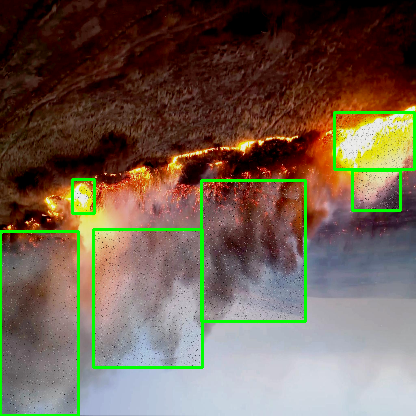

Augmented Image 4


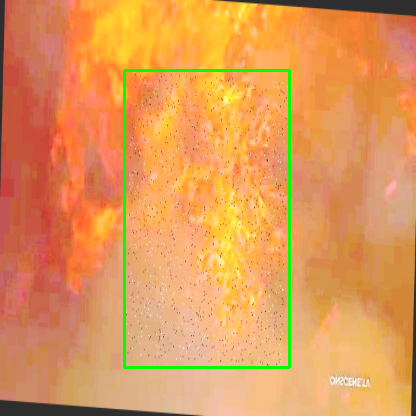

Augmented Image 4


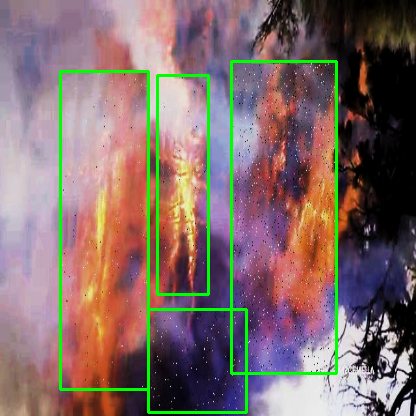

In [ ]:
# กำหนด paths
HOME = os.getcwd()
dataset_location = "/content/datasets/fire-and-smoke-detection-2"
data_yaml_path = os.path.join(dataset_location, "data.yaml")

# อ่านไฟล์ data.yaml
with open(data_yaml_path, 'r') as file:
    data = yaml.safe_load(file)

# แก้ไขไฟล์ data.yaml เพื่อเพิ่ม augmentation
data['augmentation'] = {
    'hsv_h': 0.015,  # ปรับสี Hue
    'hsv_s': 0.7,    # ปรับสี Saturation
    'hsv_v': 0.4,    # ปรับสี Value
    'flipud': 0.5,   # พลิกภาพแนวตั้ง
    'fliplr': 0.5,   # พลิกภาพแนวนอน
    'rotate': 15,    # ลดมุมการหมุนภาพ
}

# บันทึกไฟล์ data.yaml ที่แก้ไขแล้ว
with open(data_yaml_path, 'w') as file:
    yaml.safe_dump(data, file)

# โหลดโมเดล YOLOv8
model = YOLO("yolov8n.pt")

# กำหนด paths สำหรับ train images และ labels
train_image_dir = os.path.join(dataset_location, "train/images")
train_label_dir = os.path.join(dataset_location, "train/labels")

# ตัวอย่างการโหลดภาพและ label จากไดเรกทอรี train
image_files = [os.path.join(train_image_dir, f) for f in os.listdir(train_image_dir) if f.endswith('.jpg')]
label_files = [os.path.join(train_label_dir, f.replace('.jpg', '.txt')) for f in os.listdir(train_image_dir) if f.endswith('.jpg')]

# ฟังก์ชันโหลด label ในรูปแบบ YOLO
def load_yolo_labels(label_path, image_width, image_height):
    boxes = []
    class_labels = []
    with open(label_path, 'r') as file:
        for line in file:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            x_min = int((x_center - width / 2) * image_width)
            y_min = int((y_center - height / 2) * image_height)
            x_max = int((x_center + width / 2) * image_width)
            y_max = int((y_center + height / 2) * image_height)
            boxes.append([x_min, y_min, x_max, y_max])
            class_labels.append(int(class_id))
    return boxes, class_labels

# กำหนด Data Augmentation ที่ปรับปรุงแล้ว
transform = A.Compose([
    A.HorizontalFlip(p=0.5),  # พลิกภาพแนวนอน
    A.VerticalFlip(p=0.5),    # พลิกภาพแนวตั้ง
    A.Rotate(limit=15, p=0.5), # ลดมุมการหมุนภาพ
    A.RandomBrightnessContrast(p=0.3), # เพิ่มโอกาสในการปรับความสว่าง
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3), # เพิ่มโอกาสการปรับสี
    A.Resize(height=416, width=416), # ปรับขนาดภาพ
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

# สุ่มดูผล augmentation
num_samples = 3  # จำนวนตัวอย่างที่ต้องการดู
for _ in range(num_samples):
    # สุ่มเลือกภาพและ label
    idx = random.randint(0, len(image_files) - 1)
    image_path = image_files[idx]
    label_path = label_files[idx]

    # โหลดภาพและ label
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_height, image_width, _ = image.shape
    boxes, class_labels = load_yolo_labels(label_path, image_width, image_height)

    # ทำ Data Augmentation
    augmented = transform(image=image, bboxes=boxes, class_labels=class_labels)
    augmented_image = augmented['image']
    augmented_boxes = augmented['bboxes']

    # แปลง bounding box เป็นรูปแบบที่ใช้ได้กับ OpenCV
    for box in augmented_boxes:
        x_min, y_min, x_max, y_max = map(int, box)
        cv2.rectangle(augmented_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)

    # แสดงภาพและ bounding box ที่ถูก augment แล้ว
    augmented_image = cv2.cvtColor(augmented_image, cv2.COLOR_RGB2BGR)
    print(f"Augmented Image {_ + 1}")
    cv2_imshow(augmented_image)

**เพิ่มขนาดรูปและ optimizer**

In [ ]:
%cd {HOME}
!yolo task=detect mode=train model=yolov8n.pt data={dataset.location}/data.yaml epochs=50 imgsz=560 optimizer=Adam workers=120 batch=120 half=True patience=10

/content/datasets
Ultralytics 8.3.86 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/datasets/fire-and-smoke-detection-2/data.yaml, epochs=50, time=None, patience=10, batch=120, imgsz=560, save=True, save_period=-1, cache=False, device=None, workers=120, project=None, name=train, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=True, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fals

In [ ]:
# สร้างโฟลเดอร์ใน Drive
save_dir = "/content/drive/MyDrive/YOLO/yolo_models"
!mkdir -p "{save_dir}"

# คัดลอกไฟล์ best.pt และ last.pt
shutil.copy("/content/datasets/runs/detect/train/weights/best.pt", save_dir)
shutil.copy("/content/datasets/runs/detect/train/weights/last.pt", save_dir)

print(f"บันทึกไฟล์เรียบร้อยที่: {save_dir}")

บันทึกไฟล์เรียบร้อยที่: /content/drive/MyDrive/YOLO/yolo_models


In [ ]:
# กำหนด path ต้นทางและปลายทาง
source_path = "/content/datasets/runs"  # โฟลเดอร์ที่ต้องการคัดลอก
destination_path = "/content/drive/MyDrive/YOLO/yolo_train_data"  # ปลายทางใน Drive

# ลบโฟลเดอร์เก่าใน Drive (ถ้ามี)
shutil.rmtree(destination_path, ignore_errors=True)

# คัดลอกทั้งโฟลเดอร์ (รวมไฟล์ย่อย)
shutil.copytree(source_path, destination_path)

print(f"คัดลอกเสร็จสิ้น! ตรวจสอบได้ที่: {destination_path}")

คัดลอกเสร็จสิ้น! ตรวจสอบได้ที่: /content/drive/MyDrive/YOLO/yolo_train_data


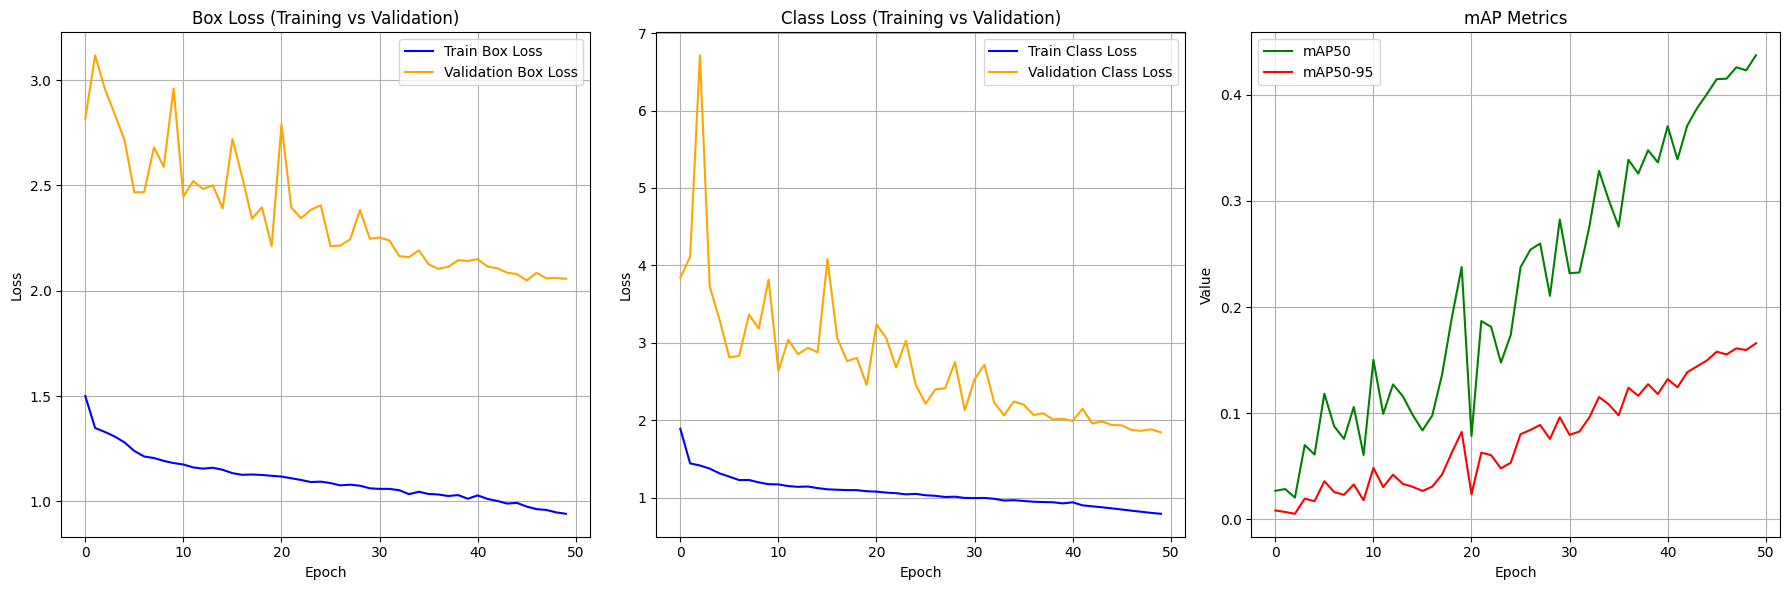

In [ ]:
# อ่านข้อมูลจากไฟล์ results.csv
results_csv = f"{HOME}/runs/detect/train/results.csv"
results = pd.read_csv(results_csv)

# สร้างกราฟ Loss และ mAP
plt.figure(figsize=(18, 6))

# แสดง Box Loss และ Class Loss
plt.subplot(1, 3, 1)
plt.plot(results['train/box_loss'], label='Train Box Loss', color='blue')
plt.plot(results['val/box_loss'], label='Validation Box Loss', color='orange')
plt.title('Box Loss (Training vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(results['train/cls_loss'], label='Train Class Loss', color='blue')
plt.plot(results['val/cls_loss'], label='Validation Class Loss', color='orange')
plt.title('Class Loss (Training vs Validation)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# แสดง mAP50(B) และ mAP50-95(B) ตามชื่อคอลัมน์จริง
plt.subplot(1, 3, 3)
plt.plot(results['metrics/mAP50(B)'], label='mAP50', color='green')
plt.plot(results['metrics/mAP50-95(B)'], label='mAP50-95', color='red')
plt.title('mAP Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# โหลดโมเดล best.pt
model = YOLO(f"{HOME}/runs/detect/train/weights/best.pt")

# ทำ Validation และสร้างรายงาน
metrics = model.val(
    data=f"{dataset.location}/data.yaml",
    split="test",
    conf=0.5,
    iou=0.5,
    plots=True
)

Ultralytics 8.3.86 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/datasets/fire-and-smoke-detection-2/test/labels... 637 images, 1 backgrounds, 0 corrupt: 100%|██████████| 637/637 [00:01<00:00, 406.94it/s]

val: New cache created: /content/datasets/fire-and-smoke-detection-2/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 40/40 [00:07<00:00,  5.34it/s]


                   all        637       1891      0.831      0.108      0.468      0.259
                  fire        459        995      0.868      0.185      0.522      0.268
                 smoke        490        896      0.794     0.0301      0.413      0.251
Speed: 0.5ms preprocess, 2.6ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/val


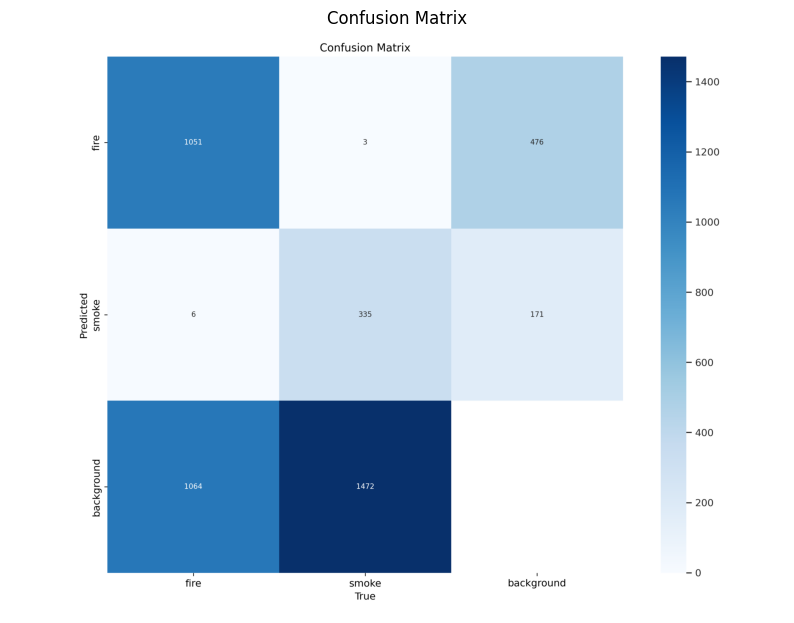


=== Performance Metrics ===
Precision (ความแม่นยำ): 0.83
Recall (การตรวจจับครบ): 0.11
mAP50: 0.47
mAP50-95: 0.26

หมายเหตุ:
- mAP50: Mean Average Precision ที่ IoU=0.5
- mAP50-95: mAP เฉลี่ยที่ IoU=0.5 ถึง 0.95
- Precision: อัตราการตรวจจับถูกต้องจากทั้งหมดที่โมเดลทำนาย
- Recall: อัตราการตรวจจับถูกต้องจากทั้งหมดที่ควรตรวจจับ


In [ ]:
# แสดง Confusion Matrix
confusion_matrix_path = f"{HOME}/runs/detect/train/confusion_matrix.png"
confusion_matrix = mpimg.imread(confusion_matrix_path)
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix)
plt.axis('off')
plt.title('Confusion Matrix')
plt.show()

# แสดงผลลัพธ์หลัก
print("\n=== Performance Metrics ===")
print(f"Precision (ความแม่นยำ): {metrics.box.mp:.2f}")
print(f"Recall (การตรวจจับครบ): {metrics.box.mr:.2f}")
print(f"mAP50: {metrics.box.map50:.2f}")
print(f"mAP50-95: {metrics.box.map:.2f}")

# คำอธิบายเพิ่มเติม
print("\nหมายเหตุ:")
print("- mAP50: Mean Average Precision ที่ IoU=0.5")
print("- mAP50-95: mAP เฉลี่ยที่ IoU=0.5 ถึง 0.95")
print("- Precision: อัตราการตรวจจับถูกต้องจากทั้งหมดที่โมเดลทำนาย")
print("- Recall: อัตราการตรวจจับถูกต้องจากทั้งหมดที่ควรตรวจจับ")

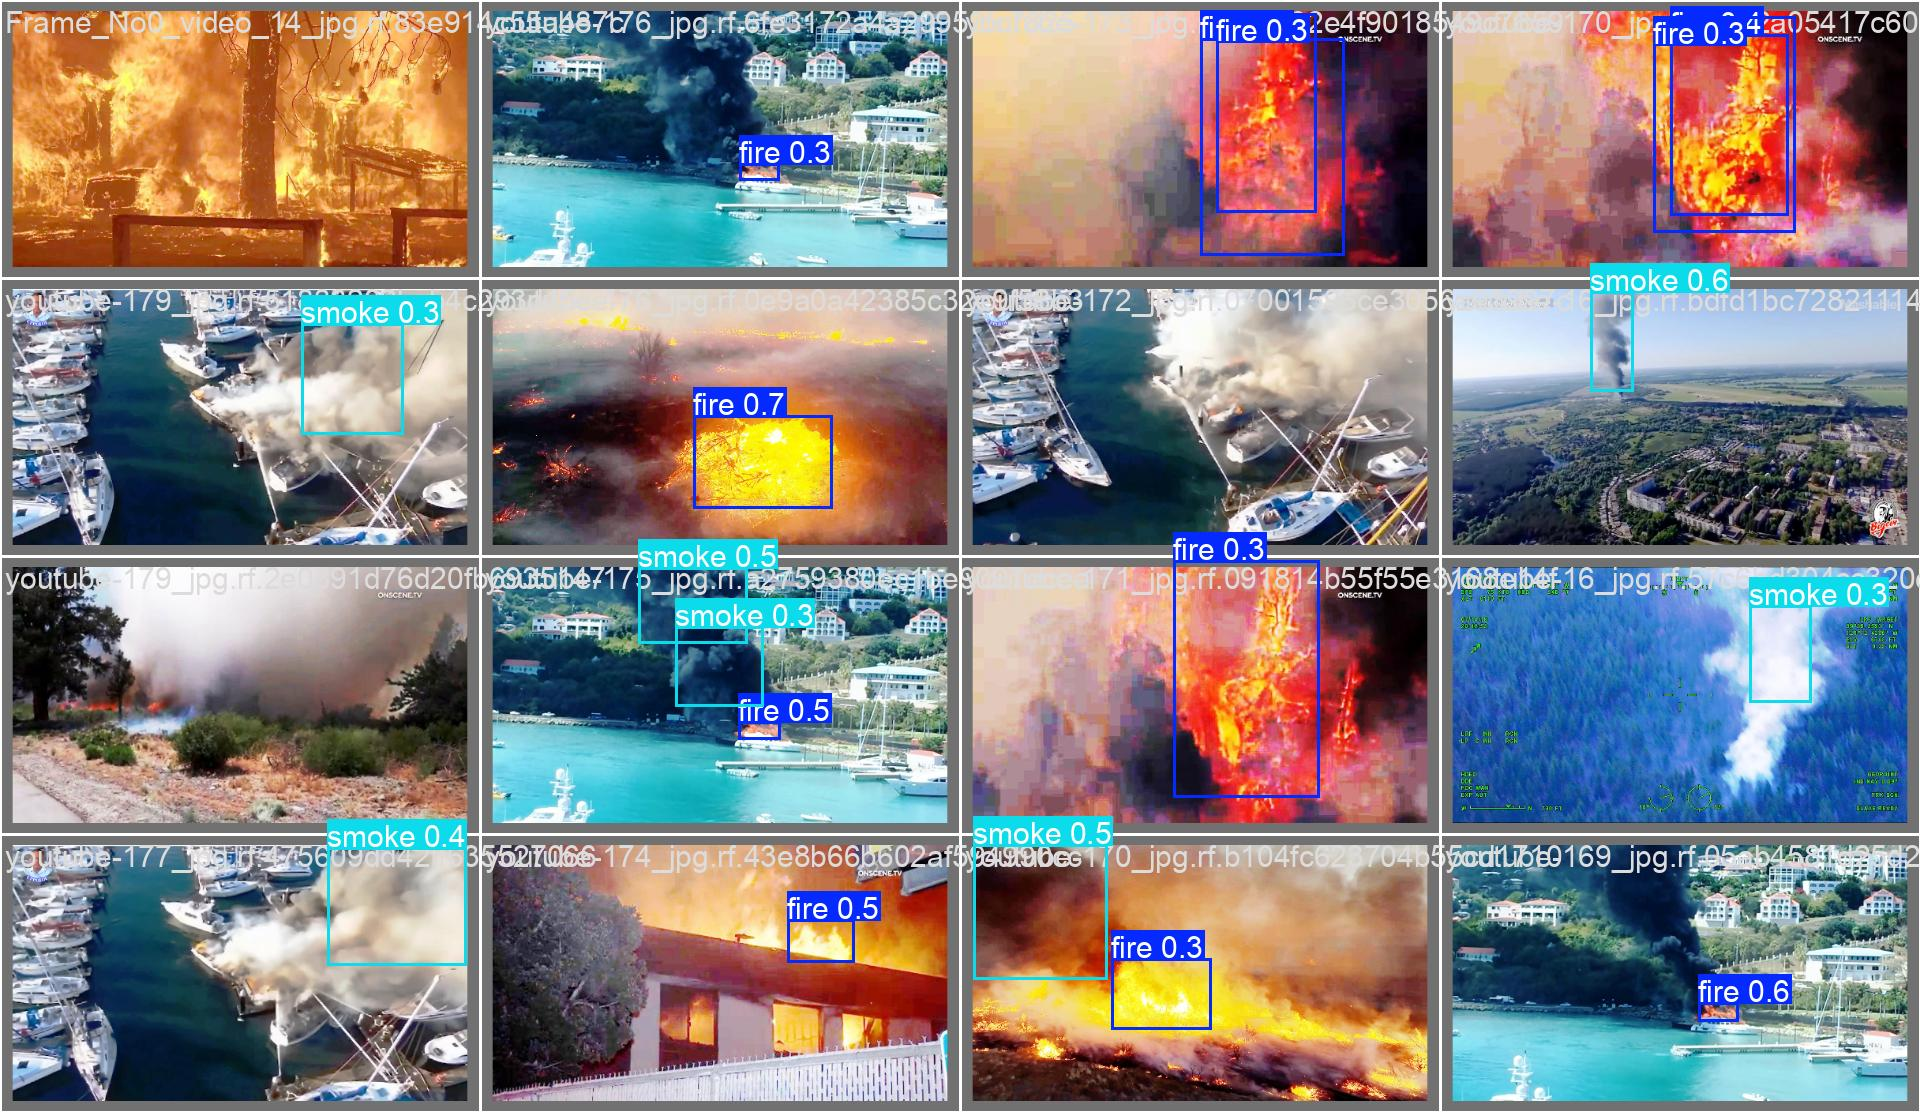

In [ ]:
for image_path in glob.glob(f'{HOME}/runs/detect/train/val_batch0_pred.jpg')[:10]:
      display(Image(filename=image_path, width=400))
      print("\n")